#Sistema de Recomendação baseado na cesta de compras, utilizando o algoritmo Apriori

##Importação das Bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder

##Leitura do arquivo com dados das notas fiscais de venda

In [2]:
basket=pd.read_csv('/content/VendaNotaFiscalClienteProduto_Abr2017_Abr2021_AF.csv',sep=';')
basket.sort_values(by='NotaFiscal')
groceries=basket[['NotaFiscal','NomeProduto']].sort_values(by='NotaFiscal')
groceries.drop_duplicates
groceries

,NotaFiscal,NomeProduto
248652,1,OCULOS RAY BAN 3546 907151 52
240101,1,PRODUTO TESTE NFCe
248653,2,OCULOS RAY BAN 3546 907151 52
248654,3,OCULOS RAY BAN 3546 907151 52
240102,3,PRODUTO TESTE NFCe
...,...,...
72319,33808,LT VS ORMA CRIZAL PREVENCIA SURFACADA
72320,33808,LT VS Orma CRIZAL EASY UV
72321,33808,ARMACAO ATITUDE 6025 T01
107556,102003700,LT ACAB. ORMA CRIZAL FORTE


##Verficação de valores nulos

In [3]:
nulos = groceries.isnull().sum()
nulos

NotaFiscal     0
NomeProduto    0
dtype: int64

##Agrupamento  dos produtos de uma mesma nota fiscal e seleção dos registros com mais de 2 itens

In [4]:
groceries = groceries.groupby(['NotaFiscal'])['NomeProduto'].apply(lambda x: ','.join(x)).reset_index()
groceries['Quant'] = groceries['NomeProduto'].str.split(',').str.len()
groceries = groceries.loc[groceries['Quant']>2]
#groceries.sort_values(by='Quant',ascending=False)
groceries

,NotaFiscal,NomeProduto,Quant
6,7,"OCULOS GRAZI MASSAFERA 4031 G098 54,ARMACAO NI...",3
7,8,"ARMACAO HICKMANN 1045 07B,OCULOS RAY BAN 2447N...",3
8,9,"LT HI VISION 1. 50 AR,ARMACAO SABRINA SATO 503...",3
17,18,"OCULOS RAY BAN 3647N 9069A5 51,ARMACAO NEXT MT...",4
19,20,"PROG HI VISION CR-39,ARMACAO ARMANI EXCHANGE 3...",7
...,...,...,...
33412,33802,"ARMACAO ROMANO RO1081 C1,OCULOS EMPORIO ARMANI...",4
33413,33803,"LT ACAB. LENTE MAR 1.56,VS POLY INCOLOR (LENT...",5
33414,33804,"ARMACAO DELUXE SHL9010 53 C2,LT KODAK PRECISE ...",3
33416,33806,"PROG DIGITAL LIGHT HD 1.5,ARMACAO ARNETTE 7175...",3



###Como se pode ver, os itens estão em uma mesma linha, separados por vírgula. Exitem duas formas de criar o onehot data frame. CountVectorizer ou TransactionEncoder. Utilizaremos a segunda opção.

## Para este exemplos vamos trabalhar com regras de associação de 3 itens

In [10]:
#Transforma o dataframe em uma lista onde cada registro é a lista dos itens de cada nota
transactions = list(groceries['NomeProduto'].apply(lambda x: sorted(x.split(','))))

#Instanciar o transcation encoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

encoder = TransactionEncoder().fit(transactions)
onehot = encoder.transform(transactions)

# converte one-hot encode data para DataFrame
onehot = pd.DataFrame(onehot, columns=encoder.columns_)
onehot.head()


,ARMACAO GUESS 2790 001 56,ARMACAO BURBERRY 2289 3773 53,ARMACAO GUESS 2652 001 50,ARMACAO GUESS 2678 001 52,ARMACAO SALVATORE FERRAGAMO 2764 646 51,ARMACAO TECNOL 3054 F867 56,ARMACAO TECNOL 3054 F868 56,ARMACAO TECNOL 3054 F869 56,ARMACAO TECNOL 3072 H496 58,ARMACAO TECNOL 3072 H498 58,ARMACAO TECNOL 3073 H500 55,ARMACAO TECNOL 3073 H501 55,ARMACAO TECNOL 3073 H502 55,ARMACAO TIMBERLAND 1613 002 51,ARMACAO TIMBERLAND 1613 009 51,ARMACAO TIMBERLAND 1657 002 57,ARMACAO TIMBERLAND 1657 009 57,ARMACAO TIMBERLAND 1657 010 57,ARMACAO TOM FORD 5575B 054 53,GRAY E BROWN),LENTE HI VISION POLARIZADA CINZA,LENTE HI VISION POLARIZADA G15,LENTE HI VISION POLARIZADA MARRON,LT SYNC III (13) 1.50 NO-RISK + BC,LT VS DIGITAL KODAK SINGLE 1.50 XPERIO MARROM,MF FREEVIEW EASY 1.49 RESINA FASTKOT SH,MF FREEVIEW H.D 1.49 RESINA,OCULOS JIMMY CHOO BEBIS PUU 539C,OCULOS SALVATORE FERRAGAMO 183S 321,OCULOS TIMBERLAND 9141 01R 55,VARILUX LIBERTY ORMA TRANS TRIO EASY CLEAN,VS PREMIUM TRIVEX BLUE CONTROL,(sell-off) PROG ULTRALUX DIGITAL HD POLARIZADA CINZA,(sell-off) PROG ULTRALUX DIGITAL HD POLARIZADA G15,(sell-off) PROG ULTRALUX DIGITAL HD POLARIZADA MARRON,(sell-off) PROG UNIQUE ALPHA POLARIZADA CINZA,(sell-off) PROG UNIQUE ALPHA POLARIZADA MARRON,(sell-off) PROG UNIQUE HT POLARIZADA CINZA,(sell-off) PROG UNIQUE HT POLARIZADA G15,(sell-off) PROG UNIQUE HT POLARIZADA MARRON,...,ZEISS SMARTLIFE ESSENTIAL PF 1.50 BLUE PROTECT,ZEISS SMARTLIFE PROG ESSENTIAL 1.50 BLUEPROTECT,ZEISS SMARTLIFE PROG ESSENTIAL 1.50 CHROME,ZEISS SMARTLIFE PROG ESSENTIAL 1.50 SILVER,ZEISS SMARTLIFE PROG ESSENTIAL 1.59 BLUEPROTECT,ZEISS SMARTLIFE PROG ESSENTIAL 1.59 PF BLUEPROTECT,ZEISS SMARTLIFE PROG ESSENTIAL 1.59 PLATINUM,ZEISS SMARTLIFE PROG ESSENTIAL 1.59 SILVER,ZEISS SMARTLIFE PROG ESSENTIAL 1.60 BLUEPROTECT,ZEISS SMARTLIFE PROG ESSENTIAL 1.60 SILVER,ZEISS SMARTLIFE PROG ESSENTIAL 1.67 BLUEPROTECT,ZEISS SMARTLIFE PROG ESSENTIAL 1.67 SILVER,ZEISS SMARTLIFE PROG PLUS 1.50 BLUEPROTECT,ZEISS SMARTLIFE PROG PLUS 1.50 CHROME,ZEISS SMARTLIFE PROG PLUS 1.74 BLUEPROTECT,ZEISS SMARTLIFE PROG PLUS PF 1.67 PLATINUM,ZEISS SMARTLIFE PROG PURE 1.50 BLUEPROTECT,ZEISS SMARTLIFE PROG PURE 1.50 CHROME,ZEISS SMARTLIFE PROG PURE 1.50 SILVER,ZEISS SMARTLIFE PROG PURE 1.59 PLATINUM,ZEISS SMARTLIFE PROG PURE 1.60 BLUEPROTECT,ZEISS SMARTLIFE PROG PURE 1.67 BLUEPROTECT,ZEISS SMARTLIFE PROG PURE 1.74 PLATINUM,ZEISS SMARTLIFE PROG PURE PF 1.67 SILVER,ZEISS SMARTLIFE PROG SUPERB 1.59 BLUEPROTECT,ZEISS SMARTLIFE PROG SUPERB 1.74 SILVER,ZEISS VS 1.50 CILÍNDRICO ESTENDIDO BLUE PROTEC,ZEISS VS 1.50 CILÍNDRICO ESTENDIDO DURAVISION SILVER,ZEISS VS 1.50 CILÍNDRICO ESTENDIDO DV CHROME,ZEISS VS 1.60 CILÍNDRICO ESTENDIDO BLUE PROTEC,ZEISS VS 1.60 CILÍNDRICO ESTENDIDO DURAVISION SILVER,ZEISS VS FREEFORM KIDS POLI+BLUE PROTEC,ZEISS VS INDIVIDUAL POLI PHOTOFUSION BLUEPROTEC UV,ZEISS VS SMARTLIFE 1.50 CHROME,ZEISS VS SMARTLIFE 1.74 BLUE PROTEC,Zeiss Prog Classic Short 1.5 Polarizada verde,Zeiss Prog Classic Short 1.6 Pola,Zeiss Prog Classic 1.67 PhotoFusion cinza,Zeiss Prog.Light 3D 1.50 DURAVISION PLATINUM,Zeiss Prog.Light 3D 1.67 DURAVISION PLATINUM
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [ ]:
#onehot.loc[(onehot ==True).any(axis=1)]

##Calculo dos itens mais frequentes através do algoritmo Apriori

In [6]:

frequent_itemsets = apriori(onehot, min_support = 0.001, max_len = 3, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.010316,( LENTE HI VISION POLARIZADA CINZA)
1,0.006358,( LENTE HI VISION POLARIZADA G15)
2,0.004969,( LENTE HI VISION POLARIZADA MARRON)
3,0.003200,( VS PREMIUM TRIVEX BLUE CONTROL)
4,0.001516,((sell-off) PROG ULTRALUX DIGITAL HD POLARIZAD...
...,...,...
6885,0.001179,"(VS POLY INCOLOR (LENTE SURF), VX COMFORT 360..."
6886,0.001811,"(VX CONFORT 360° AIRWEAR CZ EASY, VS POLY INC..."
6887,0.001179,"(VX CONFORT 360° ORMA, VS POLY INCOLOR (LENTE..."
6888,0.001263,"(VX CONFORT 360° AIRWEAR CZ EASY, VX CONFORT 3..."


##Cria as regras de associação a partir dos itens mais frequentes

In [7]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(COLORACAO PROXIMO DA AMOSTRA),( LENTE HI VISION POLARIZADA CINZA),0.186282,0.010316,0.002316,0.012432,1.205110,0.000394,1.002143
1,( LENTE HI VISION POLARIZADA CINZA),(COLORACAO PROXIMO DA AMOSTRA),0.010316,0.186282,0.002316,0.224490,1.205110,0.000394,1.049269
2,(LT ACAB. POLY AR),( LENTE HI VISION POLARIZADA CINZA),0.102531,0.010316,0.001642,0.016016,1.552547,0.000584,1.005793
3,( LENTE HI VISION POLARIZADA CINZA),(LT ACAB. POLY AR),0.010316,0.102531,0.001642,0.159184,1.552547,0.000584,1.067379
4,(LT HI VISION 1. 50 AR),( LENTE HI VISION POLARIZADA CINZA),0.182997,0.010316,0.002147,0.011735,1.137522,0.000260,1.001436
...,...,...,...,...,...,...,...,...,...
27259,"(VARILUX COMFORT ORMA CRIZAL EASY, VARILUX COM...",(VS POLY INCOLOR (LENTE SURF)),0.015790,0.084972,0.001937,0.122667,1.443613,0.000595,1.042965
27260,"(VS POLY INCOLOR (LENTE SURF), VARILUX COMFOR...",(VARILUX COMFORT ORMA CRIZAL EASY),0.005221,0.040296,0.001937,0.370968,9.205970,0.001727,1.525683
27261,(VARILUX COMFORT ORMA CRIZAL EASY),"(VS POLY INCOLOR (LENTE SURF), VARILUX COMFOR...",0.040296,0.005221,0.001937,0.048067,9.205970,0.001727,1.045009
27262,(VS POLY INCOLOR (LENTE SURF)),"(VARILUX COMFORT ORMA CRIZAL EASY, VARILUX COM...",0.084972,0.015790,0.001937,0.022795,1.443613,0.000595,1.007168


Segundo a regra acima, um produto será recomendado (consequente) a partir de outro (antecedente), com as métricas de support, confidence, lift, leverage e conviction


##Recomendação de um item, dado que ja temos 2  itens na cesta

In [8]:
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lhs items
23552,"(TRATAMENTO AR DURAVISION CHROME, LT PROG GT2 ...",(LT PROG GT2 POLI (FREEFORM)),0.004042,0.007158,0.001221,0.302083,42.201042,1.192169e-03,1.422579,2
24064,"(TRATAMENTO AR MAR, TRATAMENTO LIGHT GREEN)",(LT ZEISS PROGRESSIVE LIGHT D POLI),0.004590,0.006106,0.001053,0.229358,37.565644,1.024654e-03,1.289696,2
10903,"(LT VARILUX LIBERTY ORMA CZ EASY, COLORACAO PR...",(LT VARILUX LIBERTY ORMA),0.002569,0.016801,0.001347,0.524590,31.224290,1.304272e-03,2.068109,2
24063,"(LT ZEISS PROGRESSIVE LIGHT D POLI, TRATAMENTO...",(TRATAMENTO AR MAR),0.003074,0.012043,0.001053,0.342466,28.437829,1.015659e-03,1.502519,2
10904,"(LT VARILUX LIBERTY ORMA, COLORACAO PROXIMO D...",(LT VARILUX LIBERTY ORMA CZ EASY),0.006148,0.007874,0.001347,0.219178,27.835616,1.299019e-03,1.270617,2
...,...,...,...,...,...,...,...,...,...,...
15524,"(LT HI VISION 1. 67 AR, LT 1.5 UNIQUE HT)",(PROG ULTRALUX DIGITAL HD CR-39),0.006021,0.216556,0.001305,0.216783,1.001047,1.365212e-06,1.000289,2
17069,"(VARILUX COMFORT ORMA CRIZAL EASY, TRATAMENTO ...",(LT ACAB. LENTE MAR),0.016885,0.069771,0.001179,0.069825,1.000775,9.130963e-07,1.000058,2
15411,"(LT HI VISION 1. 50 AR, LT 1.5 UNIQUE HT)",(PROG ULTRALUX DIGITAL HD CR-39),0.010106,0.216556,0.002190,0.216667,1.000509,1.113446e-06,1.000141,2
22152,"(LT HI VISION 1.50 SURFACADA, LT HI VISION 1. ...",(PROG HI VISION CR-39),0.014443,0.183587,0.002653,0.183673,1.000473,1.253513e-06,1.000106,2


##Análise visual da Cesta de compras

Agora, mostraremos como podemos visualizar as regras de associação de análise de cesta de compras usando o mapa de calor. Mostraremos todas as regras onde o lado esquerdo consiste em 2 itens e estamos procurando por um extra.

No handles with labels found to put in legend.


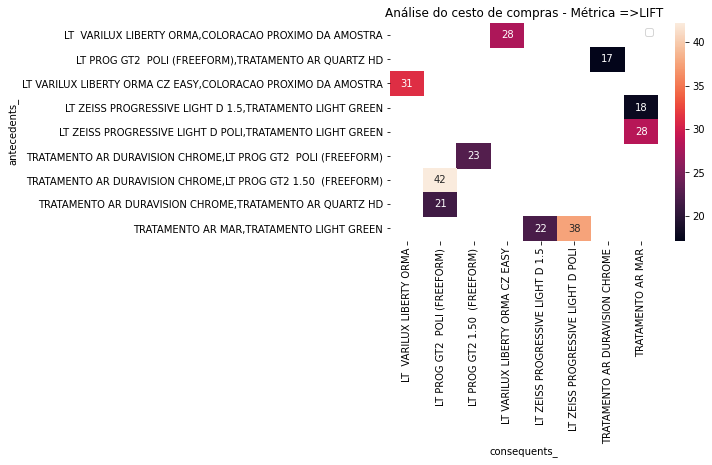

In [15]:
top_rules = rules[rules['lhs items']>1].sort_values('lift', ascending=False).head(10)

# Import seaborn under its standard alias
import seaborn as sns
import matplotlib.pyplot as plt
# Replace frozen sets with strings
top_rules['antecedents_'] = top_rules['antecedents'].apply(lambda a: ','.join(list(a)))
top_rules['consequents_'] = top_rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of top_rules into a matrix using the lift metric
pivot = top_rules[top_rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('Análise do cesto de compras - Métrica =>LIFT')
plt.legend(loc="upper right")

plt.show()